### Klasy bazowe

In [208]:
import abc
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score
import time
from statistics import mean

In [110]:
class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer."""
        pass


class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def fit(self, **kwargs):
        """Fits the model.

        Replaces original fit method.
        
        More information can be found in documentation:
        https://www.tensorflow.org/guide/eager
        https://www.tensorflow.org/guide/autodiff
        """
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts x"""
        pass

### Instrukcje pomoniczne do wykonania przetwarzania wstępnego


In [111]:
# Wczytanie zbioru danych
dataset_path = 'data/dataset.pkl'

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)

In [149]:
# Ustawienie ziarna
tf.random.set_seed(1234)

In [113]:
def get_data(part):
    images = dataset[part]['X']
    labels = dataset[part]['y']
    
    return images, labels

In [114]:
def images_preprocessing(images):
    # Zmiana rozmiaru obrazu z 224x224 do 64x64
    images = tf.image.resize(
        images, [64, 64], 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
        preserve_aspect_ratio=False,
        name=None
    )
    
    # Spłaszczanie obrazów do jednego wymiaru (np. z 64x64x3 do 12288)
    images = tf.reshape(images, [images.shape[0], -1])
    
    # Zmiana typu obrazów z int na float 
    # i normalizacja wartości pikseli z przedziału 0-255 do przedziału 0-1
    images = tf.cast(images, tf.float32) / 255.0
    
    return images

In [115]:
def labels_preprocessing(labels):
    # Zmiana wymiarowości z [8870] na [8870, 1] 
    # w celu zastosowania `SparseCategoricalCrossentropy`
    labels = tf.reshape(labels, [-1, 1])
    
    return labels

In [116]:
def dataset_to_batches(X, y, batch_size=100):
    # Preprocess images
    images = images_preprocessing(X)
    # Preprocess labels
    labels = labels_preprocessing(y)
    
    # Do iterowania zbioru danych i podzielenia na paczki (ang. batch) 
    # można wykorzystać interfejs zdefiniowany w `tensorflow.data.Dataset`
    ds = tf.data.Dataset.from_tensor_slices((images, labels)) 
    ds = ds.shuffle(buffer_size=len(images)).batch(batch_size=batch_size)
    
    return ds

In [145]:
# Wczytanie mechanizmu paczkowania dla zbiorów
train_X, train_y = get_data("train")
train_ds = dataset_to_batches(train_X, train_y)

test_X, test_y = get_data("test")
test_ds = dataset_to_batches(test_X, test_y)

val_X, val_y = get_data("validation")
val_ds = dataset_to_batches(val_X, val_y)

### Model

In [252]:
class BaseLayer(AbstractLayer):
    def __init__(self, units, inputs, activation_func, w_init, b_init):
        super(BaseLayer, self).__init__()
        
        self.units = units
        self.activation_func = activation_func

        self.weights_ = self.add_weight(shape=(inputs, units), 
                                 initializer=w_init)
        self.bias = self.add_weight(shape=(units,), 
                                 initializer=b_init)
        
        
    def call(self, inputs):
        # Podanie do przodu
        z = tf.matmul(inputs, self.weights_) + self.bias
        return self.activation_func(z)

    
class BaseModel(AbstractModel):
    def __init__(self, w_init="random_uniform", b_init="random_uniform"): 
        #super(BaseModel, self).__init__()
        super(AbstractModel, self).__init__()
        
        self.first_layer = BaseLayer(units = 256, 
                                     inputs = 12288, 
                                     activation_func = tf.keras.activations.relu, 
                                     w_init=w_init, 
                                     b_init=b_init)
        self.second_layer = BaseLayer(units = 14, 
                                      inputs = 256, 
                                      activation_func = tf.keras.activations.softmax,
                                      w_init=w_init, 
                                      b_init=b_init)

        
    def call(self, inputs, training=False):
        # Podanie do przodu przez całą sieć
        first_layer_out = self.first_layer(inputs)
        second_layer_out = self.second_layer(first_layer_out)
        
        return second_layer_out

    
    def fit(self, **kwargs):
        self.loss_list = []
        self.f1_list = []
        self.time_list = []
        
        self.test_loss_list = []
        self.test_f1_list = []
        
        self.val_loss_list = []
        self.val_f1_list = []
        
        ds_train = kwargs.get("ds_train", train_ds)
        ds_test = kwargs.get("ds_test", test_ds)
        ds_val = kwargs.get("ds_val", val_ds)
        
        batch_size = kwargs.get("batch_size", 100)
        learning_rate = kwargs.get("learning_rate", 0.001)
        optimizer = kwargs.get("optimizer", tf.keras.optimizers.Adam)
        optimizer = optimizer(learning_rate=learning_rate)
        epochs = kwargs.get("epochs", 25)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())
        
        for epoch in range(epochs):
            f1 = tfa.metrics.F1Score(num_classes=14, average="macro")
            timer_start = time.time()
            
            for X, y in ds_train:
                with tf.GradientTape() as tape:
                    logits = self.call(X)
                    loss = cost_func(y, logits)
                    
                grads = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.loss_list.append(loss)
                #self.f1_list.append(f1.result())
            
            self.f1_list.append(f1.result())
            
            exec_time = time.time() - timer_start
            self.time_list.append(exec_time)
            
            print('TRAINING: Epoch: %d  -  loss: %.3f; F1_score: %.3f; time: %.3fs'%(epoch, 
                                                                                     self.loss_list[-1], 
                                                                                     self.f1_list[-1], 
                                                                                     self.time_list[-1]))
            
            for X, y in ds_test:
                logits = self.call(X)
                loss = cost_func(y, logits)
                
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.test_loss_list.append(loss)
                self.test_f1_list.append(f1.result())
            
            print('TEST: Epoch: %d  -  loss: %.3f; F1_score: %.3f'%(epoch, 
                                                                    self.test_loss_list[-1], 
                                                                    self.test_f1_list[-1]))
            
            for X, y in ds_val:
                logits = self.call(X)
                loss = cost_func(y, logits)
                
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.val_loss_list.append(loss)
                self.val_f1_list.append(f1.result())
            
            print('VALIDATION: Epoch: %d  -  loss: %.3f; F1_score: %.3f'%(epoch, 
                                                                          self.val_loss_list[-1], 
                                                                          self.val_f1_list[-1]))
            

    def predict(self, X):
        logits = self.call(X)
        pred = tf.argmax(logits, axis=1)
        
        return pred

In [254]:
class BaseModelPlus(BaseModel):
    def __init__(self, w_init="random_uniform", b_init="random_uniform"): 
        super(AbstractModel, self).__init__()
        
        self.first_layer = BaseLayer(units = 256, 
                                     inputs = 12288, 
                                     activation_func = tf.keras.activations.relu, 
                                     w_init=w_init, 
                                     b_init=b_init)
        self.second_layer = BaseLayer(units = 256, 
                                      inputs = 256, 
                                      activation_func = tf.keras.activations.relu, 
                                      w_init=w_init, 
                                      b_init=b_init)
        self.third_layer = BaseLayer(units = 14, 
                                     inputs = 256, 
                                     activation_func = tf.keras.activations.softmax, 
                                     w_init=w_init, 
                                     b_init=b_init)

        
    def call(self, inputs, training=False):
        # Podanie do przodu przez całą sieć
        first_layer_out = self.first_layer(inputs)
        second_layer_out = self.second_layer(first_layer_out)
        third_layer_out = self.third_layer(second_layer_out)
        
        return third_layer_out

In [255]:
train_X, train_y = get_data("train")
train_ds = dataset_to_batches(train_X, train_y)

test_X, test_y = get_data("test")
test_X = images_preprocessing(test_X)
test_y = labels_preprocessing(test_y)


def base_model_experiment(ds_train=train_ds, 
                          ds_test=test_ds, 
                          ds_val=val_ds, 
                          test_X=test_X, 
                          test_y=test_y, 
                          batch_size=100, 
                          learning_rate=0.001, 
                          optimizer=tf.keras.optimizers.Adam, 
                          epochs=25, 
                          cost_func=tf.keras.losses.SparseCategoricalCrossentropy(), 
                          w_init="random_uniform", 
                          b_init="random_uniform"):
    model = BaseModel(w_init=w_init, b_init=b_init)
    
    model.fit(ds_train=ds_train, 
              ds_test=ds_test, 
              ds_val=ds_val, 
              batch_size=batch_size, 
              learning_rate=learning_rate, 
              optimizer=optimizer,
              epochs=epochs, 
              cost_func=cost_func)

    y_pred = model.predict(test_X)
    
    f1 = f1_score(test_y, y_pred, average='micro')
    
    return model, f1
    

def base_model_plus_experiment(ds_train=train_ds, 
                               ds_test=test_ds, 
                               ds_val=val_ds, 
                               test_X=test_X, 
                               test_y=test_y, 
                               batch_size=100, 
                               learning_rate=0.001, 
                               optimizer=tf.keras.optimizers.Adam, 
                               epochs=25, 
                               cost_func=tf.keras.losses.SparseCategoricalCrossentropy(), 
                               w_init="random_uniform", 
                               b_init="random_uniform"):
    model = BaseModelPlus(w_init=w_init, b_init=b_init)
    
    model.fit(ds_train=ds_train, 
              ds_test=ds_test, 
              ds_val=ds_val, 
              batch_size=batch_size, 
              learning_rate=learning_rate, 
              optimizer=optimizer,
              epochs=epochs, 
              cost_func=cost_func)

    y_pred = model.predict(test_X)
    
    f1 = f1_score(test_y, y_pred, average='micro')
    
    return model, f1

### Task 1

In [156]:
settings_w_init = ["random_uniform", "random_normal"]
settings_b_init = ["random_uniform", "random_normal"]
settings_layers_num = ['2', '3']

res_df = pd.DataFrame(columns=['layers_num', 'w_init', 'b_init', 'f1_score', 'loss'])

In [157]:
batch_size = 100
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam
epochs = 25
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()


for layers_num in settings_layers_num:
    func = base_model_experiment if layers_num == '2' else base_model_plus_experiment
    for w_init in settings_w_init:
        for b_init in settings_b_init:
            tf.random.set_seed(1234)
            
            train_X, train_y = get_data("train")
            train_ds = dataset_to_batches(train_X, train_y, batch_size)

            model, f1 = func(ds_train=train_ds, 
                             #test_X=test_X, 
                             #test_y=test_y, 
                             batch_size=batch_size, 
                             learning_rate=learning_rate, 
                             optimizer=optimizer, 
                             epochs=epochs, 
                             cost_func=cost_func, 
                             w_init=w_init, 
                             b_init=b_init)
            
            res_df = res_df.append({'layers_num': layers_num, 
                                    'w_init': w_init,  
                                    'b_init': b_init, 
                                    'f1_score': f1, 
                                    'loss': model.loss_list[-1].numpy()}, ignore_index=True)
            
            print(f1)


res_df.to_csv('out/results_1_.csv')

TRAINING: Epoch: 0  -  loss: 2.449; F1_score: 0.055; time: 2.469s
TRAINING: Epoch: 1  -  loss: 2.397; F1_score: 0.107; time: 2.412s
TRAINING: Epoch: 2  -  loss: 2.538; F1_score: 0.128; time: 2.528s
TRAINING: Epoch: 3  -  loss: 2.398; F1_score: 0.140; time: 2.661s
TRAINING: Epoch: 4  -  loss: 2.542; F1_score: 0.165; time: 2.680s
TRAINING: Epoch: 5  -  loss: 2.355; F1_score: 0.178; time: 2.666s
TRAINING: Epoch: 6  -  loss: 2.339; F1_score: 0.180; time: 2.850s
TRAINING: Epoch: 7  -  loss: 2.326; F1_score: 0.192; time: 2.702s
TRAINING: Epoch: 8  -  loss: 2.219; F1_score: 0.213; time: 2.724s
TRAINING: Epoch: 9  -  loss: 2.189; F1_score: 0.214; time: 2.797s
TRAINING: Epoch: 10  -  loss: 2.040; F1_score: 0.233; time: 2.636s
TRAINING: Epoch: 11  -  loss: 2.270; F1_score: 0.244; time: 2.685s
TRAINING: Epoch: 12  -  loss: 2.454; F1_score: 0.235; time: 2.811s
TRAINING: Epoch: 13  -  loss: 1.989; F1_score: 0.230; time: 2.763s
TRAINING: Epoch: 14  -  loss: 2.039; F1_score: 0.247; time: 3.086s
TRAIN

TRAINING: Epoch: 22  -  loss: 1.782; F1_score: 0.361; time: 3.110s
TRAINING: Epoch: 23  -  loss: 2.025; F1_score: 0.379; time: 3.247s
TRAINING: Epoch: 24  -  loss: 1.497; F1_score: 0.392; time: 3.479s
0.2545515846257586
TRAINING: Epoch: 0  -  loss: 2.383; F1_score: 0.067; time: 2.688s
TRAINING: Epoch: 1  -  loss: 2.368; F1_score: 0.104; time: 2.754s
TRAINING: Epoch: 2  -  loss: 2.527; F1_score: 0.125; time: 2.689s
TRAINING: Epoch: 3  -  loss: 2.437; F1_score: 0.157; time: 2.671s
TRAINING: Epoch: 4  -  loss: 2.505; F1_score: 0.161; time: 2.791s
TRAINING: Epoch: 5  -  loss: 2.440; F1_score: 0.180; time: 2.752s
TRAINING: Epoch: 6  -  loss: 2.314; F1_score: 0.196; time: 2.686s
TRAINING: Epoch: 7  -  loss: 2.291; F1_score: 0.206; time: 2.639s
TRAINING: Epoch: 8  -  loss: 2.243; F1_score: 0.218; time: 2.673s
TRAINING: Epoch: 9  -  loss: 2.215; F1_score: 0.234; time: 2.685s
TRAINING: Epoch: 10  -  loss: 2.018; F1_score: 0.242; time: 2.944s
TRAINING: Epoch: 11  -  loss: 2.220; F1_score: 0.245;

In [200]:
file_path = 'out/results_1.csv'

df = pd.read_csv(file_path, index_col=0)

df

layers_num          w_init          b_init  f1_score      loss
0           2  random_uniform  random_uniform  0.233311  1.570602
1           2  random_uniform   random_normal  0.231962  1.630924
2           2   random_normal  random_uniform  0.220836  1.568689
3           2   random_normal   random_normal  0.231962  1.620402
4           3  random_uniform  random_uniform  0.254552  1.497458
5           3  random_uniform   random_normal  0.256237  1.632841
6           3   random_normal  random_uniform  0.267701  1.251542
7           3   random_normal   random_normal  0.197572  1.724484

### Task 2

In [171]:
settings_epochs = [20, 30]
settings_learning_rate = [0.0001, 0.001, 0.01]
settings_optimizer = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]
settings_batch_size = [100, 250, 500]

res_df = pd.DataFrame(columns=['epochs', 'learning_rate', 'optimizer', 'batch_size', 
                               'f1_score', 'loss', 'time_per_epoch', 'time'])

In [172]:
w_init="random_normal"
b_init="random_uniform"
func = base_model_plus_experiment # 3 layers model
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()

for epochs in settings_epochs:
    for learning_rate in settings_learning_rate:
        for optimizer in settings_optimizer:
            for batch_size in settings_batch_size:
                tf.random.set_seed(1234)
                
                train_X, train_y = get_data("train")
                train_ds = dataset_to_batches(train_X, train_y, batch_size)
                
                model, f1 = func(ds_train=train_ds, 
                                 #test_X=test_X, 
                                 #test_y=test_y, 
                                 batch_size=batch_size, 
                                 learning_rate=learning_rate, 
                                 optimizer=optimizer, 
                                 epochs=epochs, 
                                 cost_func=cost_func, 
                                 w_init=w_init, 
                                 b_init=b_init)
                
                res_df = res_df.append({'epochs': epochs, 
                                        'learning_rate': learning_rate,  
                                        'optimizer': optimizer.__name__, 
                                        'batch_size': batch_size, 
                                        'f1_score': f1, 
                                        'loss': model.loss_list[-1].numpy(), 
                                        'time_per_epoch': np.mean(model.time_list), 
                                        'time': np.sum(model.time_list)}, ignore_index=True)
                
                print(f1)


res_df.to_csv('out/results_2_3_layers_.csv')

TRAINING: Epoch: 0  -  loss: 2.429; F1_score: 0.071; time: 2.758s
TRAINING: Epoch: 1  -  loss: 2.406; F1_score: 0.115; time: 2.627s
TRAINING: Epoch: 2  -  loss: 2.544; F1_score: 0.140; time: 2.787s
TRAINING: Epoch: 3  -  loss: 2.353; F1_score: 0.166; time: 2.771s
TRAINING: Epoch: 4  -  loss: 2.489; F1_score: 0.173; time: 2.681s
TRAINING: Epoch: 5  -  loss: 2.343; F1_score: 0.192; time: 2.814s
TRAINING: Epoch: 6  -  loss: 2.297; F1_score: 0.212; time: 2.962s
TRAINING: Epoch: 7  -  loss: 2.201; F1_score: 0.221; time: 2.920s
TRAINING: Epoch: 8  -  loss: 2.257; F1_score: 0.229; time: 2.828s
TRAINING: Epoch: 9  -  loss: 2.176; F1_score: 0.246; time: 2.945s
TRAINING: Epoch: 10  -  loss: 1.998; F1_score: 0.261; time: 2.935s
TRAINING: Epoch: 11  -  loss: 2.138; F1_score: 0.275; time: 2.941s
TRAINING: Epoch: 12  -  loss: 2.278; F1_score: 0.287; time: 3.266s
TRAINING: Epoch: 13  -  loss: 1.924; F1_score: 0.308; time: 3.217s
TRAINING: Epoch: 14  -  loss: 1.857; F1_score: 0.312; time: 3.340s
TRAIN

TRAINING: Epoch: 2  -  loss: 2.560; F1_score: 0.144; time: 3.078s
TRAINING: Epoch: 3  -  loss: 2.385; F1_score: 0.161; time: 3.042s
TRAINING: Epoch: 4  -  loss: 2.446; F1_score: 0.175; time: 2.938s
TRAINING: Epoch: 5  -  loss: 2.327; F1_score: 0.202; time: 2.679s
TRAINING: Epoch: 6  -  loss: 2.296; F1_score: 0.209; time: 2.770s
TRAINING: Epoch: 7  -  loss: 2.179; F1_score: 0.215; time: 2.797s
TRAINING: Epoch: 8  -  loss: 2.174; F1_score: 0.234; time: 2.812s
TRAINING: Epoch: 9  -  loss: 2.159; F1_score: 0.252; time: 2.843s
TRAINING: Epoch: 10  -  loss: 1.964; F1_score: 0.263; time: 2.878s
TRAINING: Epoch: 11  -  loss: 2.153; F1_score: 0.283; time: 2.865s
TRAINING: Epoch: 12  -  loss: 2.084; F1_score: 0.307; time: 3.221s
TRAINING: Epoch: 13  -  loss: 1.940; F1_score: 0.316; time: 2.959s
TRAINING: Epoch: 14  -  loss: 1.936; F1_score: 0.323; time: 2.975s
TRAINING: Epoch: 15  -  loss: 1.794; F1_score: 0.336; time: 3.058s
TRAINING: Epoch: 16  -  loss: 1.943; F1_score: 0.348; time: 2.988s
TRA

TRAINING: Epoch: 4  -  loss: 14.506; F1_score: 0.014; time: 2.572s
TRAINING: Epoch: 5  -  loss: 14.506; F1_score: 0.014; time: 2.595s
TRAINING: Epoch: 6  -  loss: 14.967; F1_score: 0.014; time: 2.614s
TRAINING: Epoch: 7  -  loss: 14.046; F1_score: 0.014; time: 2.634s
TRAINING: Epoch: 8  -  loss: 15.197; F1_score: 0.014; time: 2.665s
TRAINING: Epoch: 9  -  loss: 14.276; F1_score: 0.014; time: 2.707s
TRAINING: Epoch: 10  -  loss: 14.506; F1_score: 0.014; time: 2.728s
TRAINING: Epoch: 11  -  loss: 13.585; F1_score: 0.014; time: 2.745s
TRAINING: Epoch: 12  -  loss: 15.197; F1_score: 0.014; time: 2.785s
TRAINING: Epoch: 13  -  loss: 13.355; F1_score: 0.014; time: 2.815s
TRAINING: Epoch: 14  -  loss: 13.355; F1_score: 0.014; time: 2.854s
TRAINING: Epoch: 15  -  loss: 14.046; F1_score: 0.014; time: 2.890s
TRAINING: Epoch: 16  -  loss: 14.506; F1_score: 0.014; time: 2.923s
TRAINING: Epoch: 17  -  loss: 14.276; F1_score: 0.014; time: 2.930s
TRAINING: Epoch: 18  -  loss: 13.816; F1_score: 0.014;

TRAINING: Epoch: 5  -  loss: 2.343; F1_score: 0.192; time: 2.607s
TRAINING: Epoch: 6  -  loss: 2.297; F1_score: 0.212; time: 2.667s
TRAINING: Epoch: 7  -  loss: 2.201; F1_score: 0.221; time: 2.711s
TRAINING: Epoch: 8  -  loss: 2.257; F1_score: 0.229; time: 2.693s
TRAINING: Epoch: 9  -  loss: 2.176; F1_score: 0.246; time: 2.815s
TRAINING: Epoch: 10  -  loss: 1.998; F1_score: 0.261; time: 2.755s
TRAINING: Epoch: 11  -  loss: 2.138; F1_score: 0.275; time: 2.781s
TRAINING: Epoch: 12  -  loss: 2.278; F1_score: 0.287; time: 2.922s
TRAINING: Epoch: 13  -  loss: 1.924; F1_score: 0.308; time: 2.950s
TRAINING: Epoch: 14  -  loss: 1.857; F1_score: 0.312; time: 2.881s
TRAINING: Epoch: 15  -  loss: 1.855; F1_score: 0.333; time: 2.942s
TRAINING: Epoch: 16  -  loss: 1.896; F1_score: 0.346; time: 2.984s
TRAINING: Epoch: 17  -  loss: 1.865; F1_score: 0.358; time: 3.055s
TRAINING: Epoch: 18  -  loss: 1.834; F1_score: 0.387; time: 3.125s
TRAINING: Epoch: 19  -  loss: 1.584; F1_score: 0.400; time: 3.159s


TRAINING: Epoch: 7  -  loss: 2.663; F1_score: 0.057; time: 1.498s
TRAINING: Epoch: 8  -  loss: 2.713; F1_score: 0.054; time: 1.502s
TRAINING: Epoch: 9  -  loss: 2.678; F1_score: 0.054; time: 1.517s
TRAINING: Epoch: 10  -  loss: 2.553; F1_score: 0.053; time: 1.524s
TRAINING: Epoch: 11  -  loss: 2.618; F1_score: 0.051; time: 1.518s
TRAINING: Epoch: 12  -  loss: 2.691; F1_score: 0.051; time: 1.512s
TRAINING: Epoch: 13  -  loss: 2.559; F1_score: 0.051; time: 1.525s
TRAINING: Epoch: 14  -  loss: 2.577; F1_score: 0.052; time: 1.530s
TRAINING: Epoch: 15  -  loss: 2.682; F1_score: 0.052; time: 1.554s
TRAINING: Epoch: 16  -  loss: 2.634; F1_score: 0.052; time: 1.559s
TRAINING: Epoch: 17  -  loss: 2.614; F1_score: 0.052; time: 1.550s
TRAINING: Epoch: 18  -  loss: 2.608; F1_score: 0.052; time: 1.551s
TRAINING: Epoch: 19  -  loss: 2.554; F1_score: 0.053; time: 1.557s
TRAINING: Epoch: 20  -  loss: 2.614; F1_score: 0.053; time: 1.566s
TRAINING: Epoch: 21  -  loss: 2.594; F1_score: 0.053; time: 1.560

TRAINING: Epoch: 9  -  loss: 2.254; F1_score: 0.191; time: 1.495s
TRAINING: Epoch: 10  -  loss: 2.218; F1_score: 0.208; time: 1.510s
TRAINING: Epoch: 11  -  loss: 2.219; F1_score: 0.209; time: 1.497s
TRAINING: Epoch: 12  -  loss: 2.200; F1_score: 0.225; time: 1.502s
TRAINING: Epoch: 13  -  loss: 2.211; F1_score: 0.231; time: 1.501s
TRAINING: Epoch: 14  -  loss: 2.129; F1_score: 0.248; time: 1.511s
TRAINING: Epoch: 15  -  loss: 2.140; F1_score: 0.255; time: 1.525s
TRAINING: Epoch: 16  -  loss: 2.101; F1_score: 0.271; time: 1.511s
TRAINING: Epoch: 17  -  loss: 2.086; F1_score: 0.278; time: 1.508s
TRAINING: Epoch: 18  -  loss: 2.112; F1_score: 0.291; time: 1.509s
TRAINING: Epoch: 19  -  loss: 2.128; F1_score: 0.294; time: 1.548s
TRAINING: Epoch: 20  -  loss: 1.942; F1_score: 0.304; time: 1.543s
TRAINING: Epoch: 21  -  loss: 1.923; F1_score: 0.317; time: 1.539s
TRAINING: Epoch: 22  -  loss: 2.003; F1_score: 0.324; time: 1.532s
TRAINING: Epoch: 23  -  loss: 1.979; F1_score: 0.328; time: 1.5

TRAINING: Epoch: 11  -  loss: 13.585; F1_score: 0.014; time: 2.842s
TRAINING: Epoch: 12  -  loss: 15.197; F1_score: 0.014; time: 2.859s
TRAINING: Epoch: 13  -  loss: 13.355; F1_score: 0.014; time: 2.889s
TRAINING: Epoch: 14  -  loss: 13.355; F1_score: 0.014; time: 3.254s
TRAINING: Epoch: 15  -  loss: 14.046; F1_score: 0.014; time: 3.164s
TRAINING: Epoch: 16  -  loss: 14.506; F1_score: 0.014; time: 3.133s
TRAINING: Epoch: 17  -  loss: 14.276; F1_score: 0.014; time: 3.115s
TRAINING: Epoch: 18  -  loss: 13.816; F1_score: 0.014; time: 3.111s
TRAINING: Epoch: 19  -  loss: 14.276; F1_score: 0.014; time: 3.126s
TRAINING: Epoch: 20  -  loss: 15.197; F1_score: 0.014; time: 3.152s
TRAINING: Epoch: 21  -  loss: 13.816; F1_score: 0.014; time: 3.398s
TRAINING: Epoch: 22  -  loss: 12.664; F1_score: 0.014; time: 3.316s
TRAINING: Epoch: 23  -  loss: 14.046; F1_score: 0.014; time: 3.429s
TRAINING: Epoch: 24  -  loss: 13.585; F1_score: 0.014; time: 3.334s
TRAINING: Epoch: 25  -  loss: 14.276; F1_score: 

TRAINING: Epoch: 12  -  loss: 2.383; F1_score: 0.160; time: 1.554s
TRAINING: Epoch: 13  -  loss: 2.164; F1_score: 0.166; time: 1.578s
TRAINING: Epoch: 14  -  loss: 2.243; F1_score: 0.168; time: 1.529s
TRAINING: Epoch: 15  -  loss: 2.249; F1_score: 0.173; time: 1.541s
TRAINING: Epoch: 16  -  loss: 2.267; F1_score: 0.179; time: 1.546s
TRAINING: Epoch: 17  -  loss: 2.254; F1_score: 0.184; time: 1.537s
TRAINING: Epoch: 18  -  loss: 2.226; F1_score: 0.187; time: 1.545s
TRAINING: Epoch: 19  -  loss: 2.156; F1_score: 0.192; time: 1.564s
TRAINING: Epoch: 20  -  loss: 2.231; F1_score: 0.194; time: 1.560s
TRAINING: Epoch: 21  -  loss: 2.113; F1_score: 0.196; time: 1.559s
TRAINING: Epoch: 22  -  loss: 2.206; F1_score: 0.199; time: 1.559s
TRAINING: Epoch: 23  -  loss: 2.310; F1_score: 0.206; time: 1.569s
TRAINING: Epoch: 24  -  loss: 2.191; F1_score: 0.201; time: 1.575s
TRAINING: Epoch: 25  -  loss: 2.186; F1_score: 0.207; time: 1.592s
TRAINING: Epoch: 26  -  loss: 2.230; F1_score: 0.215; time: 1.

In [201]:
#file_path = 'out/results_2_2_layers.csv' # w_init="random_uniform" b_init="random_uniform"
file_path = 'out/results_2_3_layers.csv' # w_init="random_normal" b_init="random_uniform"

df = pd.read_csv(file_path, index_col=0)

df

epochs  learning_rate optimizer  batch_size  f1_score       loss  \
0       20         0.0001      Adam         100  0.272758   1.583878   
1       20         0.0001      Adam         250  0.265341   1.876163   
2       20         0.0001      Adam         500  0.258260   2.072254   
3       20         0.0001       SGD         100  0.164531   2.466582   
4       20         0.0001       SGD         250  0.159137   2.554088   
5       20         0.0001       SGD         500  0.144302   2.615820   
6       20         0.0010      Adam         100  0.239380   1.559647   
7       20         0.0010      Adam         250  0.248146   1.822643   
8       20         0.0010      Adam         500  0.225219   2.127867   
9       20         0.0010       SGD         100  0.211396   2.221395   
10      20         0.0010       SGD         250  0.192515   2.407130   
11      20         0.0010       SGD         500  0.172623   2.501276   
12      20         0.0100      Adam         100  0.109575  14.276029   
13      20         0.0100      Adam         250  0.167903  12.894479   
14      20         0.0100      Adam         500  0.109575  14.244915   
15      20         0.0100       SGD         100  0.255563   1.879136   
16      20         0.0100       SGD         250  0.235334   2.155570   
17      20         0.0100       SGD         500  0.226231   2.287831   
18      30         0.0001      Adam         100  0.268375   1.499656   
19      30         0.0001      Adam         250  0.281187   1.728913   
20      30         0.0001      Adam         500  0.270398   1.947344   
21      30         0.0001       SGD         100  0.165543   2.559108   
22      30         0.0001       SGD         250  0.161834   2.599766   
23      30         0.0001       SGD         500  0.152057   2.633819   
24      30         0.0010      Adam         100  0.235671   1.739877   
25      30         0.0010      Adam         250  0.243763   1.458145   
26      30         0.0010      Adam         500  0.248483   1.870666   
27      30         0.0010       SGD         100  0.223871   2.365467   
28      30         0.0010       SGD         250  0.204653   2.467134   
29      30         0.0010       SGD         500  0.182738   2.535691   
30      30         0.0100      Adam         100  0.109575  14.506288   
31      30         0.0100      Adam         250  0.167903  13.566065   
32      30         0.0100      Adam         500  0.109575  14.680540   
33      30         0.0100       SGD         100  0.257586   1.997976   
34      30         0.0100       SGD         250  0.228928   2.239035   
35      30         0.0100       SGD         500  0.225893   2.330074   

    time_per_epoch       time  
0         2.998797  59.975950  
1         1.993842  39.876842  
2         1.597594  31.951871  
3         2.705919  54.118384  
4         1.583950  31.678998  
5         1.578311  31.566229  
6         2.996411  59.928227  
7         1.751356  35.027116  
8         1.679904  33.598081  
9         2.727735  54.554693  
10        1.618226  32.364515  
11        1.489493  29.789853  
12        2.725360  54.507197  
13        1.595362  31.907250  
14        1.502975  30.059494  
15        2.541306  50.826128  
16        1.526687  30.533735  
17        1.471509  29.430177  
18        2.962729  88.881868  
19        1.684135  50.524062  
20        1.547509  46.425264  
21        2.783860  83.515805  
22        1.538229  46.146881  
23        1.466151  43.984542  
24        2.935283  88.058479  
25        1.627394  48.821823  
26        1.512293  45.368804  
27        2.673272  80.198170  
28        1.538919  46.167558  
29        1.468054  44.041626  
30        3.012773  90.383191  
31        1.622006  48.660167  
32        1.511685  45.350561  
33        2.678834  80.365008  
34        1.542336  46.270072  
35        1.440722  43.221670

### Task 3

#### Zadanie 1
W zadaniu pierwszym obiektem badań był wpływ następujących hiperparametrów modelu, na efekty uczenia:
- Metody inicjalizacji wag i biasów
    - badano następujące ustawienia: {random_uniform, random_normal}
- Liczba warstw modelu
    - badano modele o ilości warstw wynoszącej: {2, 3}

Najleprze wyniki (F1 = 0.256237) otrzymano dla usatwień:
- inicjalizacji wag = random_uniform
- inicjalizacji biasów = random_normal
- lcizba warstw = 3


#### Zadanie 2
W zadaniu drugim obiektem badań był wpływ następujących hiperparametrów modelu, na efekty uczenia:
- Liczba epok uczenia
    - badano następujące ilości epok: {20, 30}
- Metoda optymalizacji modelu wraz z przebadaniem różnych wartości współczynnika uczenia
    - badano następujące metody optymalizacji: {Adam, SGD}
    - w zestawieniu z wartościami współczynnika uczenia: {0.0001, 0.001, 0.01}
- Różne liczności paczek (mini batch)
    - badano ilości paczek: {100, 250, 500}

Najleprze wyniki (F1 = 0.281187) otrzymano dla usatwień:
- ilość epok = 30
- metoda optymalizacji = Adam
- wartość współczynnika uczenia = 0.0001
- wielkość paczek = 250

#### Wnioski
- inicjalizacja wag sposobem w oparciu o rozkład jednostajny daje lepsze wyniki
- inicjalizacja biasów wydaje się nie mieć jednoznacznego wpływu na jakość wyników
- lepsze wyniki uzyskano z modelu o 3 warstwach
- nimeal zawsze lepsze wyniki uzyskuje się ustawiając mniejszą wielkość paczek, jednak przekłada się to na dłuższy czas uczenia
- zwiększenie epok uczenia zwykle polepsza wyniki
- optymalizator Adam działa lepiej w zestawieniem z niższymi ustawieniami wartości współczynnika uczenia
- optymalizator SGD działa lepiej w zestawieniem z wyższymi ustawieniami wartości współczynnika uczenia
- uczenie modelu w oparciu o optymalizator Adam przekłada się na nieznaczenie dłuższy czas uczenia

### Task 4

In [256]:
# Zbiór szkoleniowy
tf.random.set_seed(1234)

# Zbiór testowy
#ds_test = test_ds

# Zbiór walidacyjny
#ds_val = val_ds

# Wielkość paczki: 100
batch_size = 250

train_X, train_y = get_data("train")
train_ds = dataset_to_batches(train_X, train_y, batch_size)

test_X, test_y = get_data("test")
test_ds = dataset_to_batches(test_X, test_y, batch_size)

val_X, val_y = get_data("validation")
val_ds = dataset_to_batches(val_X, val_y, batch_size)

# Współczynnik uczenia: 0.001
learning_rate = 0.0001

# Optymalizator: Adam
optimizer = tf.keras.optimizers.Adam

# Liczba epok: 25
epochs = 30

# Funkcja kosztu: tf.keras.losses.SparseCategoricalCrossentropy
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()

func = base_model_plus_experiment # 3 layers model

w_init="random_normal"
b_init="random_uniform"

model, f1 = func(ds_train=train_ds, 
                 ds_test=test_ds, 
                 ds_val=val_ds,
                 #test_X=test_X, 
                 #test_y=test_y, 
                 batch_size=batch_size, 
                 learning_rate=learning_rate, 
                 optimizer=optimizer, 
                 epochs=epochs, 
                 cost_func=cost_func, 
                 w_init=w_init, 
                 b_init=b_init)

TRAINING: Epoch: 0  -  loss: 2.459; F1_score: 0.072; time: 1.759s
TEST: Epoch: 0  -  loss: 2.449; F1_score: 0.076
VALIDATION: Epoch: 0  -  loss: 2.503; F1_score: 0.077
TRAINING: Epoch: 1  -  loss: 2.357; F1_score: 0.106; time: 1.704s
TEST: Epoch: 1  -  loss: 2.452; F1_score: 0.105
VALIDATION: Epoch: 1  -  loss: 2.491; F1_score: 0.104
TRAINING: Epoch: 2  -  loss: 2.466; F1_score: 0.131; time: 1.693s
TEST: Epoch: 2  -  loss: 2.344; F1_score: 0.129
VALIDATION: Epoch: 2  -  loss: 2.397; F1_score: 0.128
TRAINING: Epoch: 3  -  loss: 2.402; F1_score: 0.154; time: 1.729s
TEST: Epoch: 3  -  loss: 2.345; F1_score: 0.153
VALIDATION: Epoch: 3  -  loss: 2.367; F1_score: 0.151
TRAINING: Epoch: 4  -  loss: 2.396; F1_score: 0.169; time: 1.776s
TEST: Epoch: 4  -  loss: 2.333; F1_score: 0.160
VALIDATION: Epoch: 4  -  loss: 2.369; F1_score: 0.155
TRAINING: Epoch: 5  -  loss: 2.282; F1_score: 0.182; time: 1.685s
TEST: Epoch: 5  -  loss: 2.384; F1_score: 0.177
VALIDATION: Epoch: 5  -  loss: 2.338; F1_score

In [257]:
print(f1)

0.28354686446392446


Text(0.5, 1.0, 'Train dataset loss')

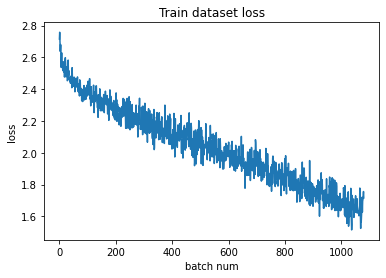

In [274]:
plt.plot(model.loss_list)
plt.xlabel("batch num")
plt.ylabel("loss")
plt.title("Train dataset loss")

Text(0.5, 1.0, 'Train dataset F1-score')

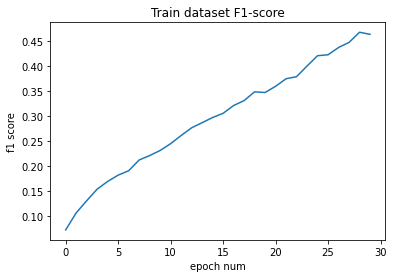

In [275]:
plt.plot(model.f1_list)
plt.xlabel("epoch num")
plt.ylabel("f1 score")
plt.title("Train dataset F1-score")

Text(0.5, 1.0, 'Test dataset loss')

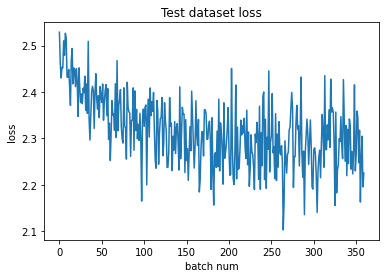

In [271]:
plt.plot(model.test_loss_list)
plt.xlabel("batch num")
plt.ylabel("loss")
plt.title("Test dataset loss")

Text(0.5, 1.0, 'Test dataset F1-score')

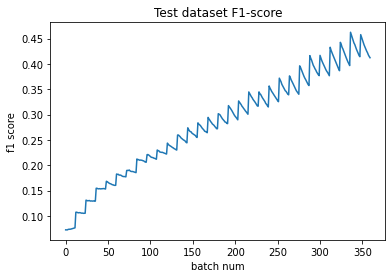

In [270]:
plt.plot(model.test_f1_list)
plt.xlabel("batch num")
plt.ylabel("f1 score")
plt.title("Test dataset F1-score")

Text(0.5, 1.0, 'Validation dataset loss')

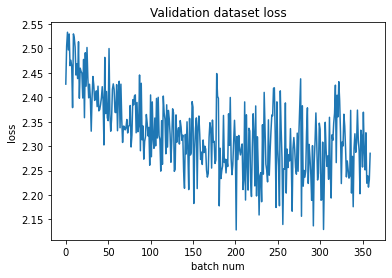

In [267]:
plt.plot(model.val_loss_list)
plt.xlabel("batch num")
plt.ylabel("loss")
plt.title("Validation dataset loss")

Text(0.5, 1.0, 'Validation dataset F1-score')

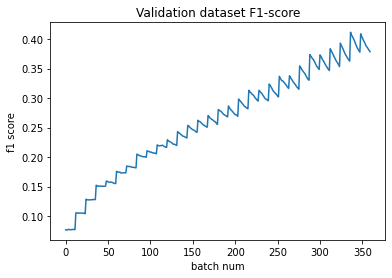

In [269]:
plt.plot(model.val_f1_list)
plt.xlabel("batch num")
plt.ylabel("f1 score")
plt.title("Validation dataset F1-score")

In [196]:
classes = list(dataset['labels_mapping'].keys())

classes

['indo-islamic',
 'chinese',
 'art_deco',
 'secession',
 'romanesque',
 'byzantine',
 'russian_revival',
 'victorian_quenn_anne',
 'neoclassical',
 'postmodernism',
 'baroque',
 'achaemenid',
 'ancient',
 'renaissance']

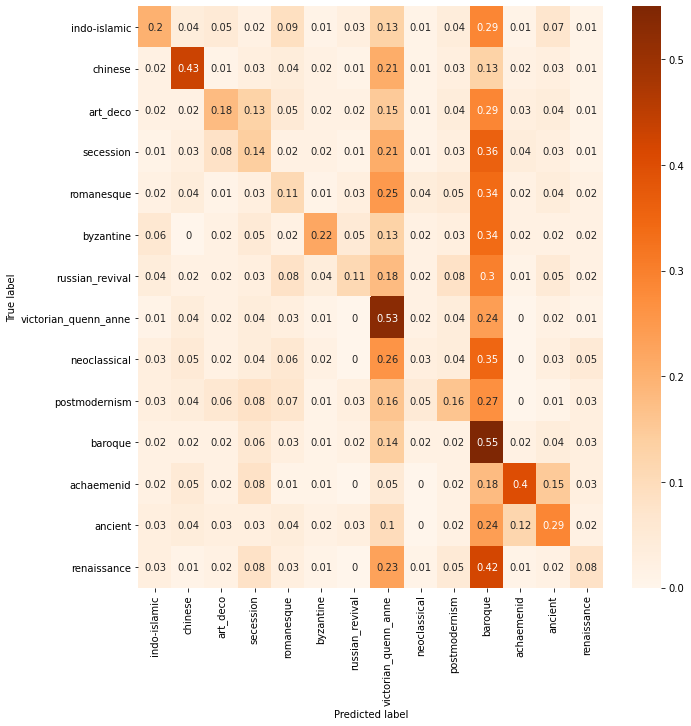

In [197]:
test_X, test_y = get_data("test")
test_X = images_preprocessing(test_X)
test_y = labels_preprocessing(test_y)

y_pred = model.predict(test_X)

con_mat = tf.math.confusion_matrix(labels=test_y, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes, 
                          columns = classes)

figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Oranges)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [198]:
def display_image_with_pred(image, pred_class):
    plt.imshow(image)
    title = 'Pred class: ' + str(pred_class)
    plt.title(title)
    plt.show()

===== REAL CLASS: indo-islamic =====


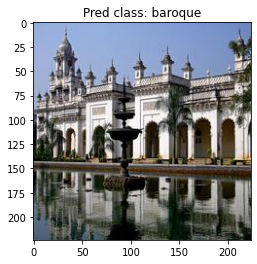

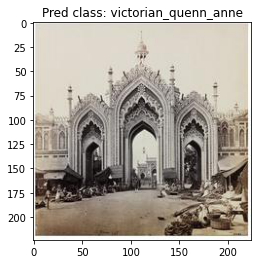

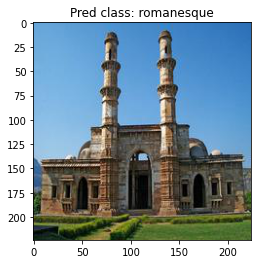

===== REAL CLASS: chinese =====


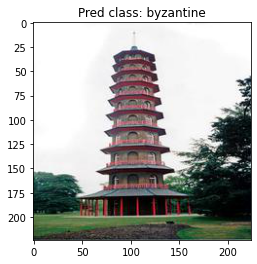

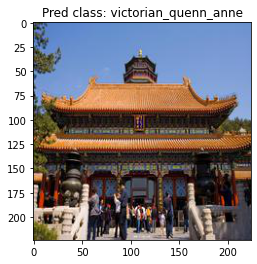

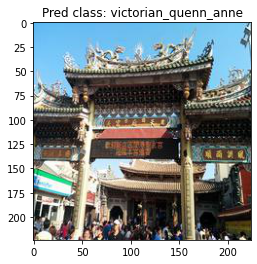

===== REAL CLASS: art_deco =====


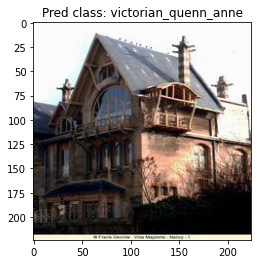

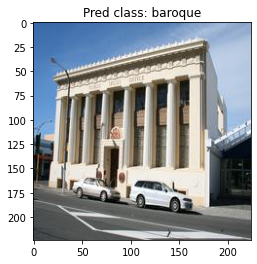

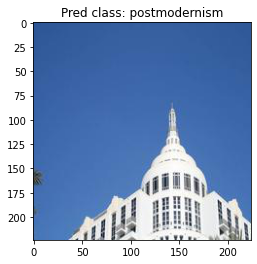

===== REAL CLASS: secession =====


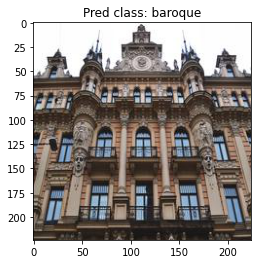

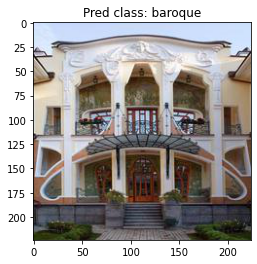

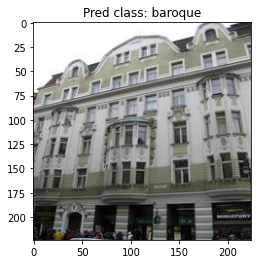

===== REAL CLASS: romanesque =====


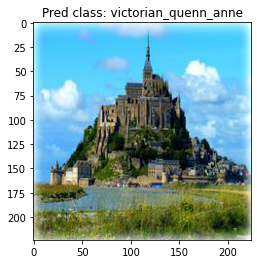

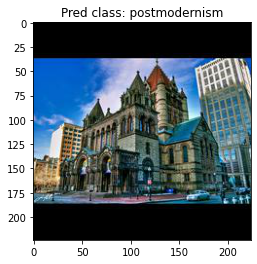

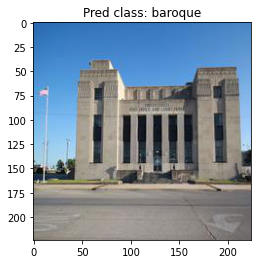

===== REAL CLASS: byzantine =====


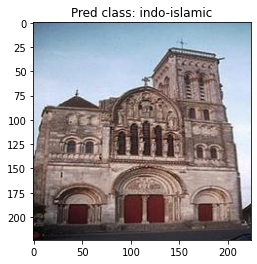

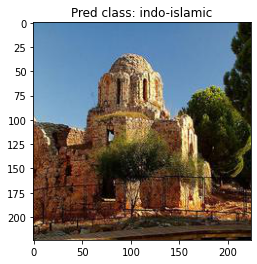

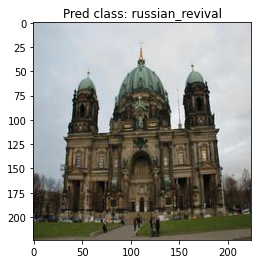

===== REAL CLASS: russian_revival =====


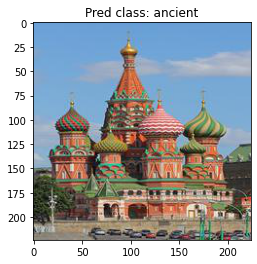

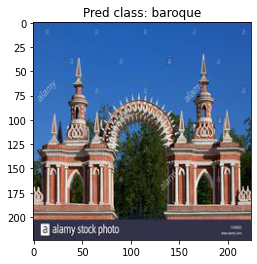

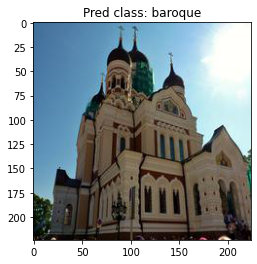

===== REAL CLASS: victorian_quenn_anne =====


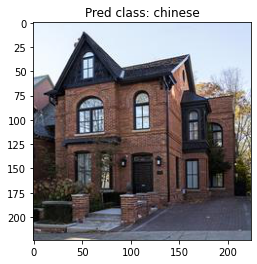

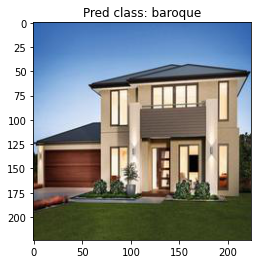

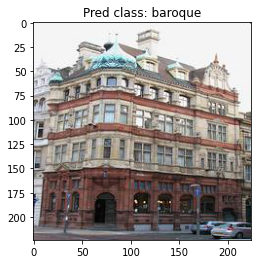

===== REAL CLASS: neoclassical =====


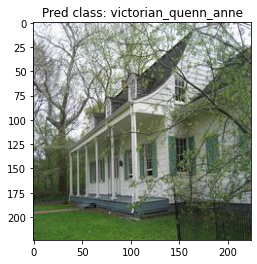

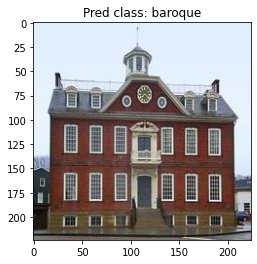

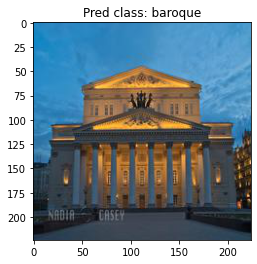

===== REAL CLASS: postmodernism =====


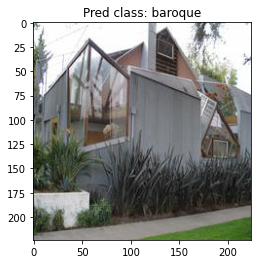

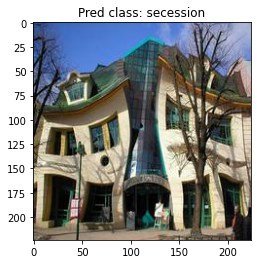

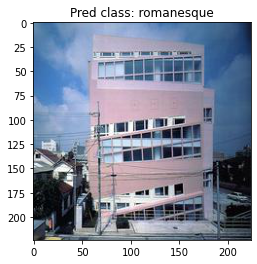

===== REAL CLASS: baroque =====


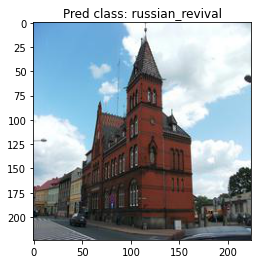

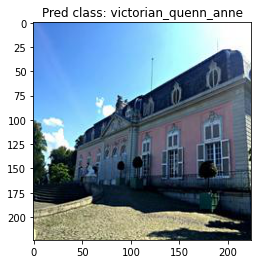

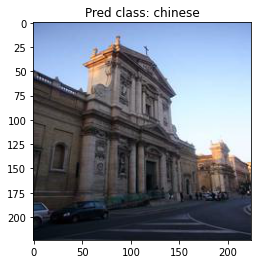

===== REAL CLASS: achaemenid =====


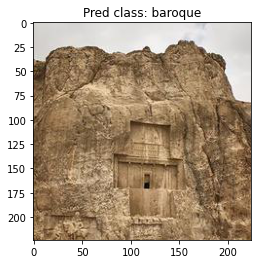

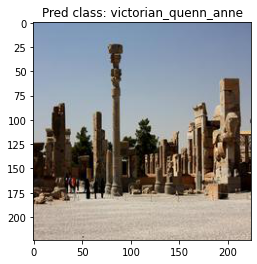

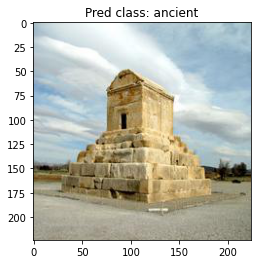

===== REAL CLASS: ancient =====


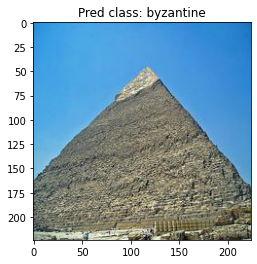

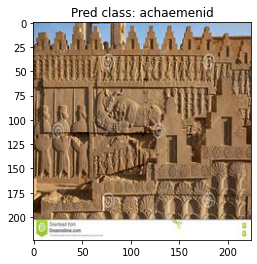

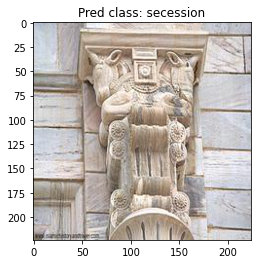

===== REAL CLASS: renaissance =====


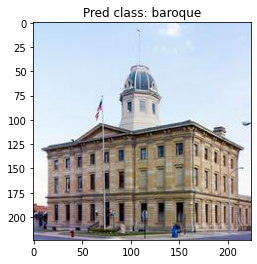

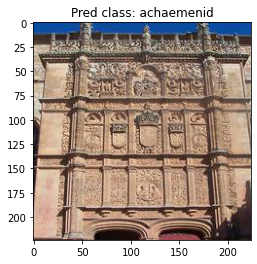

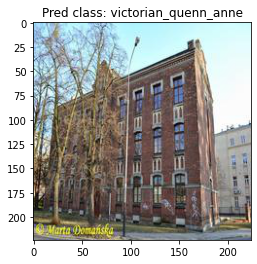

In [199]:
NUM_OF_INCORRRECT_PER_CLASS = 3

test_X, test_y = get_data("test")
test_y = labels_preprocessing(test_y)

for class_num in range(len(classes)):
    print('===== REAL CLASS:', classes[class_num], '=====')
    
    cnt = NUM_OF_INCORRRECT_PER_CLASS
    for image, label, pred in zip(test_X, test_y, y_pred):
        if label.numpy()[0] == class_num:
            if pred != label and cnt > 0:
                display_image_with_pred(image, classes[pred])
                cnt -= 1